# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

#reproducability
np.random.seed(0)

# Load train/test
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [2]:
trn_raw = pd.read_feather('tmp/train_regid31')
tst_raw = pd.read_feather('tmp/tst_regid31')

trn = trn_raw.copy()
tst = tst_raw.copy()

columns_dep_var= 'cc.vote16'

In [3]:
with open('tmp/catcont_regid31.json') as f:
    data1 = json.load(f)

    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
    
# res_cont
# res_cat

In [4]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [5]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

57888
6432


## Categorify and Fill Missing

In [6]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [7]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [8]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [9]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [10]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 55, total tst columns = 55
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [11]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

set()

set()

In [12]:
#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

In [ ]:
#find the index of the column in trn
# idx=trn.columns.tolist().index('cc.catholic_na')
# idx
# type(trn.columns)

In [ ]:
# tst.insert(loc=idx, column='cc.catholic_na', value=False)

# Train a RandomForest on all data

In [13]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#create a random forest object
m_rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=5)

In [14]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    res = [rmse(m.predict(trn), trn_y), rmse(m.predict(tst), tst_y),
                m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [15]:
#train the random forest 
m_rf.fit(trn, trn_y)

#how good is it? R**2 => 1 means perfect, 0 means always predicts the mean, - value less than 1/2 right 
m_rf.score(trn,trn_y)

print_score(m_rf, trn, trn_y, tst, tst_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

0.8709058872305141

[0.8641583327734066, 0.9549882133106089, 0.8709058872305141, 0.7863805970149254, 0.783271144278607]


# Test the model on test data

In [16]:
def eval_accuracy(preds,targs):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    print(f"Got {matches} right out of {totals} samples, Accuracy is {100*matches/totals} percent")

In [17]:
preds1 = m_rf.predict(tst)

eval_accuracy(preds1,tst_y)

Got 5058 right out of 6432 samples, Accuracy is 78.63805970149254 percent


# Figure out which features are important
How is the model making predictions?  What matters?  What features give the most information gain, that is seperate trump voters from non-trump voters?

Use this information to select only relevant features to train the model on, this simplifies the model while preserving accuracy.  And simplicity tends toward better generalization.

In [18]:
#copied from fastai structured.py
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [19]:
#lets figure out whats most important (top 20 out of 32)
fi = rf_feat_importance(m_rf, trn); fi[:20]

cols       imp
30                cc.raceviewsum  0.155548
27                  cc.cc16_422d  0.114030
46                      cc.ideo7  0.072745
29                  cc.cc16_422f  0.061899
53                     cc.repdum  0.053612
33                        cc.age  0.047557
28                  cc.cc16_422e  0.046696
26                  cc.cc16_422c  0.042856
45                    cc.newsint  0.038104
25                 cc.immviewsum  0.037232
1                    cc.cc16_304  0.020252
23                 cc.cc16_331_7  0.018264
21                 cc.cc16_331_2  0.014395
52                 demo.popdense  0.013991
38               cc.citylength_1  0.013966
2                      cc.faminc  0.013722
51                 relig.evan.pc  0.013533
50                     eth.his.p  0.013052
20  mort.ucd.despair.disc95.pdpy  0.012882
49                cc.religiosity  0.012799

In [20]:
type(fi)
fi['imp'].sum() #should be 1

pandas.core.frame.DataFrame

1.0

cols    cc.raceviewsumcc.cc16_422dcc.ideo7cc.cc16_422f...
imp                                                     1
dtype: object

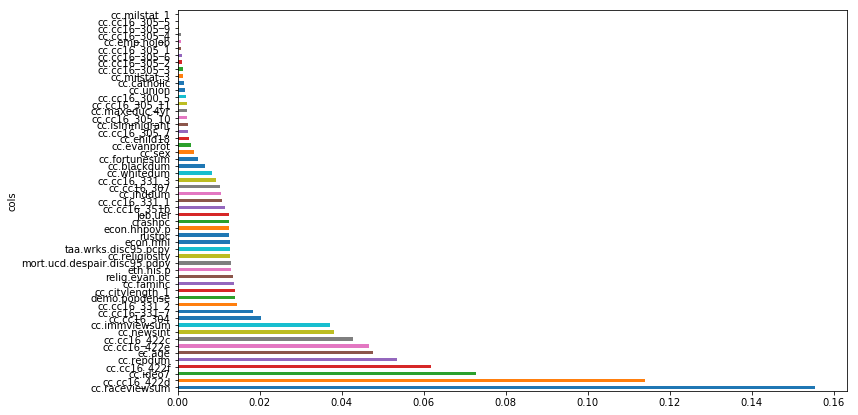

In [21]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:]);
fi.sum()

As you can see most of the above do not matter, lets see what happens when we only use those that account for >.005 (greater than half a percent)

In [22]:
to_keep=fi[fi.imp>0.008].cols; len(to_keep)
# to_keep

32

In [23]:
type(fi)

pandas.core.frame.DataFrame

## Lets try permutation based feature importance
Should be more accurate but is computationally expensive see <a href="https://explained.ai/rf-importance/index.html#5">Beware Default Random Forest Importances</a>

In [24]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

trn_pb=trn.copy()
trn_pb_y=trn_y.copy()

In [25]:

#the following calculates how each feature affects the result
#First it gets the baseline metric (r**2) for the entire set  (trn_pb, trn_pb_y)
#then it permutes a single feature (randomly scrambling that column)
#then calculates the metric (r**2) for the entire set (trn_pb, trn_pb_y)
#then it subtracts that from the baseline to see how that metric affects the predictions
feature_importance = permutation_importances(m_rf, trn_pb, trn_pb_y, r2)

In [33]:
feature_importance_tst = permutation_importances(m_rf, tst.copy(), tst_y.copy(), r2)

In [ ]:
# feature_importance
# feature_importance_tst

In [26]:
perm_imp_rfpimp = feature_importance.copy().reset_index()

In [27]:
# perm_imp_rfpimp
# perm_imp_rfpimp.dtypes
# perm_imp_rfpimp.columns

# tmp = perm_imp_rfpimp.copy()
# type(tmp)

# type(tmp['Feature'][0])

Feature  Importance
0                 cc.raceviewsum    0.259156
1                     cc.newsint    0.098797
2                   cc.cc16_422c    0.090489
3                   cc.cc16_422d    0.089451
4                       cc.ideo7    0.058744
5                         cc.age    0.057409
6                   cc.cc16_422e    0.050585
7                   cc.cc16_422f    0.042575
8                      cc.repdum    0.041388
9                  cc.immviewsum    0.035157
10                     cc.faminc    0.033229
11                 cc.cc16_331_7    0.032636
12                   cc.cc16_304    0.029965
13                 cc.cc16_331_2    0.024180
14               cc.citylength_1    0.020916
15                 demo.popdense    0.020323
16                   cc.cc16_307    0.020175
17                  cc.cc16_351b    0.017356
18                       crashpc    0.016466
19  mort.ucd.despair.disc95.pdpy    0.015131
20                 cc.cc16_331_3    0.014686
21                      econ.mhi    0.013944
22          taa.wrks.disc95.pcpy    0.013796
23                       job.uer    0.013499
24                     eth.his.p    0.013499
25                 cc.cc16_331_1    0.012609
26                 relig.evan.pc    0.012164
27                     cc.inddum    0.012164
28                cc.religiosity    0.012016
29                        cc.sex    0.011422
30                  econ.hhpov.p    0.011274
31                        rustpc    0.010977
32                cc.isimmigrant    0.010236
33                cc.cc16_305_11    0.009197
34                   cc.whitedum    0.008307
35                cc.maxeduc.4yr    0.007269
36                   cc.evanprot    0.007269
37                 cc.fortunesum    0.006972
38                    cc.child18    0.005340
39                   cc.blackdum    0.005044
40                  cc.milstat_3    0.004450
41                cc.cc16_305_10    0.003709
42                 cc.cc16_305_7    0.003560
43                 cc.cc16_300_5    0.002522
44                      cc.union    0.002225
45                  cc.emp.nojob    0.001483
46                 cc.cc16_305_6    0.000593
47                 cc.cc16_305_4    0.000148
48                   cc.catholic    0.000148
49                 cc.cc16_305_5    0.000000
50                 cc.cc16_305_9    0.000000
51                  cc.milstat_1    0.000000
52                 cc.cc16_305_1   -0.000148
53                 cc.cc16_305_3   -0.001335
54                 cc.cc16_305_2   -0.001483

Feature        object
Importance    float64
dtype: object

Index(['Feature', 'Importance'], dtype='object')

pandas.core.frame.DataFrame

55

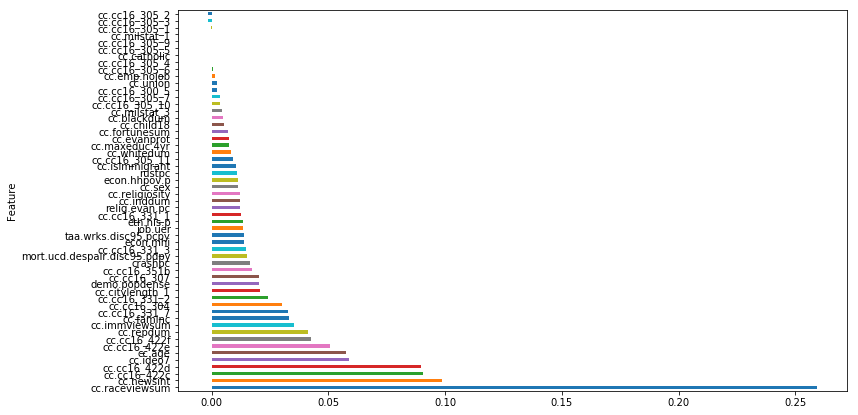

In [28]:
type(perm_imp_rfpimp)
len(perm_imp_rfpimp)
# perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
perm_imp_rfpimp.plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

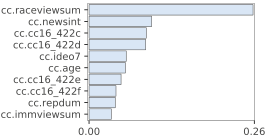

In [30]:
#just a different way to plot above (uses OOB)
from rfpimp import plot_importances
plot_importances(feature_importance[:10])
# perm_imp_rfpimp

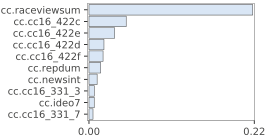

In [34]:
plot_importances(feature_importance_tst[:10])

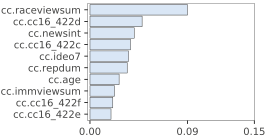

In [36]:
#same as permutation_importances except uses validation set, much, much faster since no loop
from rfpimp import importances
ret = importances(m_rf, trn, trn_y, features=None, n_samples=5000, sort=True, metric=None, sample_weights = None)
plot_importances(ret[:10])

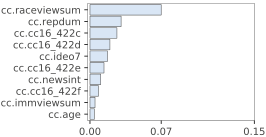

In [37]:
ret_tst = importances(m_rf, tst, tst_y, features=None, n_samples=5000, sort=True, metric=None, sample_weights = None)
plot_importances(ret_tst[:10])

In [38]:
# to_keep=fi[fi.imp>0.008].cols; len(to_keep)
to_keep = perm_imp_rfpimp[perm_imp_rfpimp['Importance']>.005].Feature;len(to_keep)


40

# Train a new RandomForest only on important features (drop others)

In [39]:
#create new trn set, keep only columns listed above
trn_keep = trn[to_keep].copy()
tst_keep = tst[to_keep].copy()

In [40]:
m1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                        oob_score=True, max_features='auto', min_samples_leaf=5)
m1.fit(trn_keep, trn_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [41]:
print_score(m1, trn_keep, trn_y, tst_keep, tst_y )
#[0.1732101326060013, 0.2419867915197795, 0.8791258627822779, 0.7647816350511024, 0.7456946960198437]  all columns
#[0.17700665876025426, 0.24587567779382105, 0.8737690044685158, 0.7571606597054799, 0.7375853110086588] >.005 
#[0.18575200658248822, 0.2495160868663049, 0.860987508681502, 0.7499165190396515, 0.7320435625302746] >.01
#[0.25006557227754617, 0.2478853283763553, 0.7480614603264728, 0.7531747702776621, 0.7236431805106943] >.02

#[0.26964518916289276, 0.265588825604379, 0.7070644017734026, 0.7166602533514237, 0.6910908074614164] >.05

[0.8620868595767758, 0.9552323829690014, 0.87114773355445, 0.7860696517412935, 0.7822864842454395]


In [42]:
preds1 = m1.predict(tst_keep)

eval_accuracy(preds1,tst_y)

Got 5056 right out of 6432 samples, Accuracy is 78.60696517412936 percent


<B>So accuracy and R**2 drop as you drop columns, but not by much.  Also if you just keep the top 4 columns, your accuracy drops to 90.5% from 92%

So what predicts a trump voter?
- cc.ideo7 (by far the biggest) 
- cc.raceviewsum
- cc.immviewsum
- cc.repdum	</b>

# Remove redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. You should be able to remove these correlated features without degrading the OOB score (or R**2 or accuracy) of the model.  In fact the model is simpler so its performence may go up.

The following dendrogram using spearman ranked correlation to get correlations between features.  Start from the right and see which features combine, those are closer together in rank than those not on that fork.  For an excellent overview see <a href="https://www.statisticshowto.datasciencecentral.com/hierarchical-clustering/"> Hierarchical Clustering / Dendrogram</a></strong>

In [43]:
from scipy.cluster import hierarchy as hc

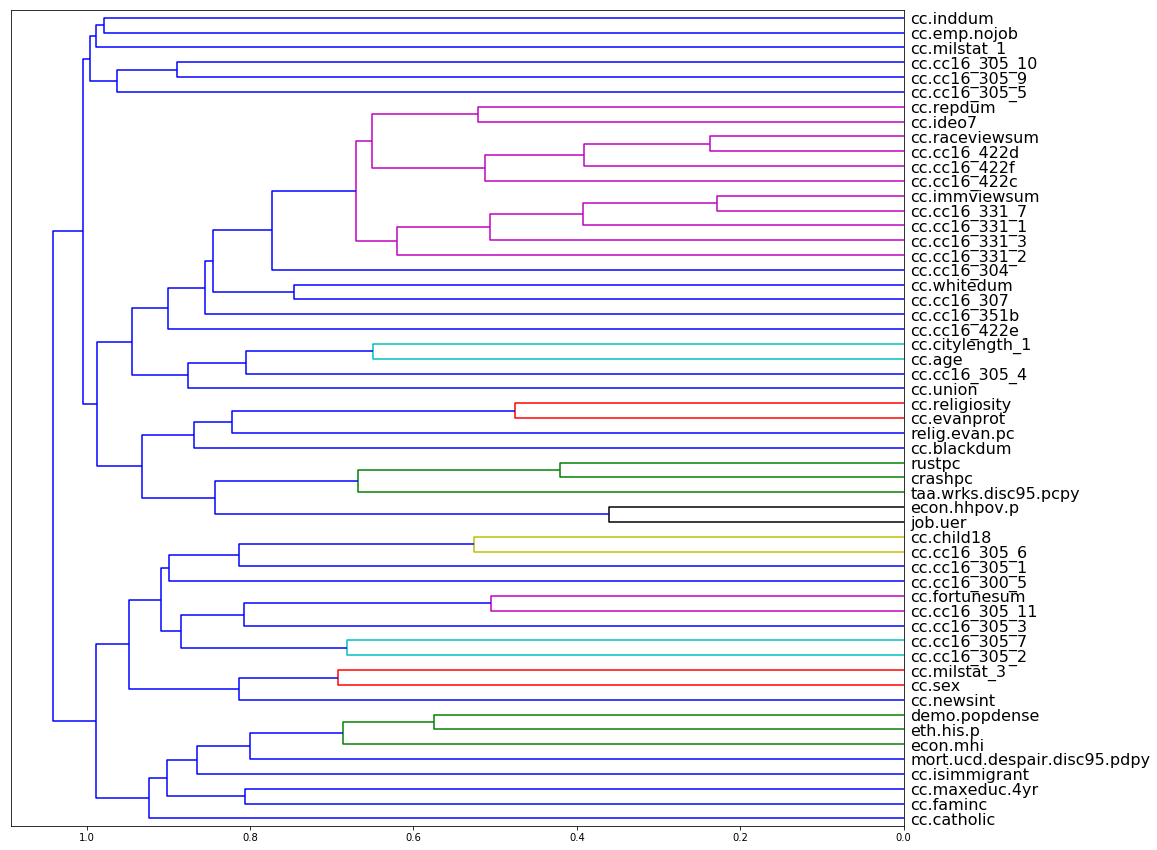

In [44]:
corr = np.round(scipy.stats.spearmanr(trn).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=trn.columns, orientation='left', leaf_font_size=16)
plt.show()

Notice the x axis starts at 1 and goes to 0.  If 2 features are linked at or near 0 then they are highly correlated.  Im seeing that for several _na columns.  These columns are added when there is at least 1 row that has a NaN for that column. If a row has an autofilled value for that column then the _na column is set to True, otherwise its false.  My guess is several of these columns have the same values in them.  In any case we could probably remove them an d not affect the models accuracy.

so.. dump cc.repdum_na keep cc.inddumna
dump econ.hhpov.p_na,econ.mhi_na, demo+popdense_na, taa.wrks..._na, keep job.uer_na
dump crash_pc_na keep rustpc_na
or some combo of above.

In [45]:
def get_oob(df,y):
    m= RandomForestClassifier(n_estimators=40,  min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

#get unaltered score
get_oob(trn, trn_y)

0.7814227473742399

In [ ]:
# train_eval_dropped_columns = trn.copy()

# to_drop=['crashpc_na','econ.hhpov.p_na', 'econ.mhi_na','demo.popdense_na','job.uer_na','cc.repdum_na']
# for c in to_drop:
#     print(c, get_oob(trn.copy().drop(c, axis=1), trn_y))

Hmmm... Not much savings here.  

# Partial Dependence

In [46]:
from pdpbox import pdp
from plotnine import *

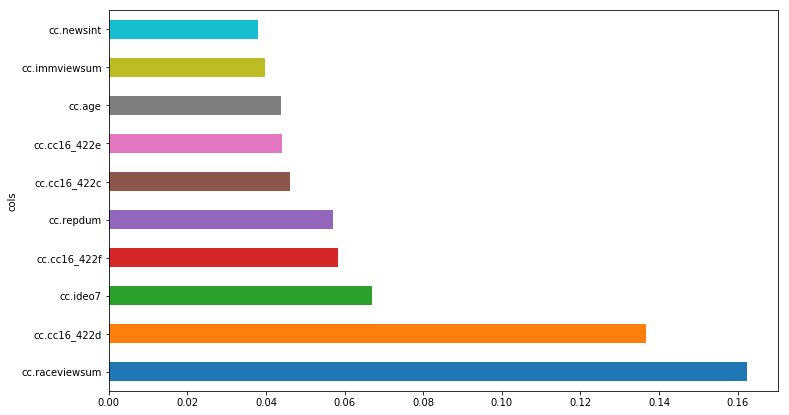

In [47]:
#top 10 
plot_fi(rf_feat_importance(m1, trn_keep)[:10]);

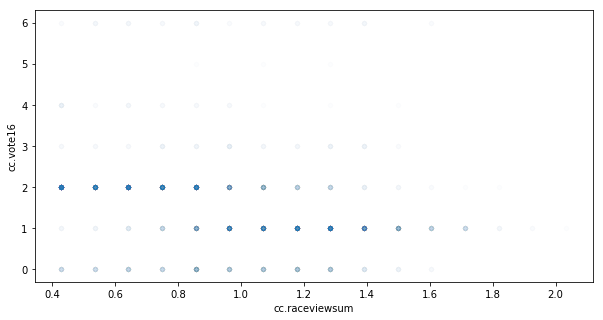

In [48]:
#looks like cc.raceviewsum matters a lot, lets plot it against dependent var
trn_raw[:2000].plot('cc.raceviewsum', columns_dep_var,kind='scatter', alpha=0.01, figsize=(10,5));

In [49]:
import matplotlib.font_manager
def plot_pdp(feat, m, x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)


/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.

/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.

/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.



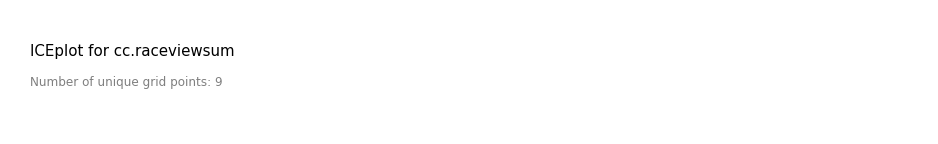

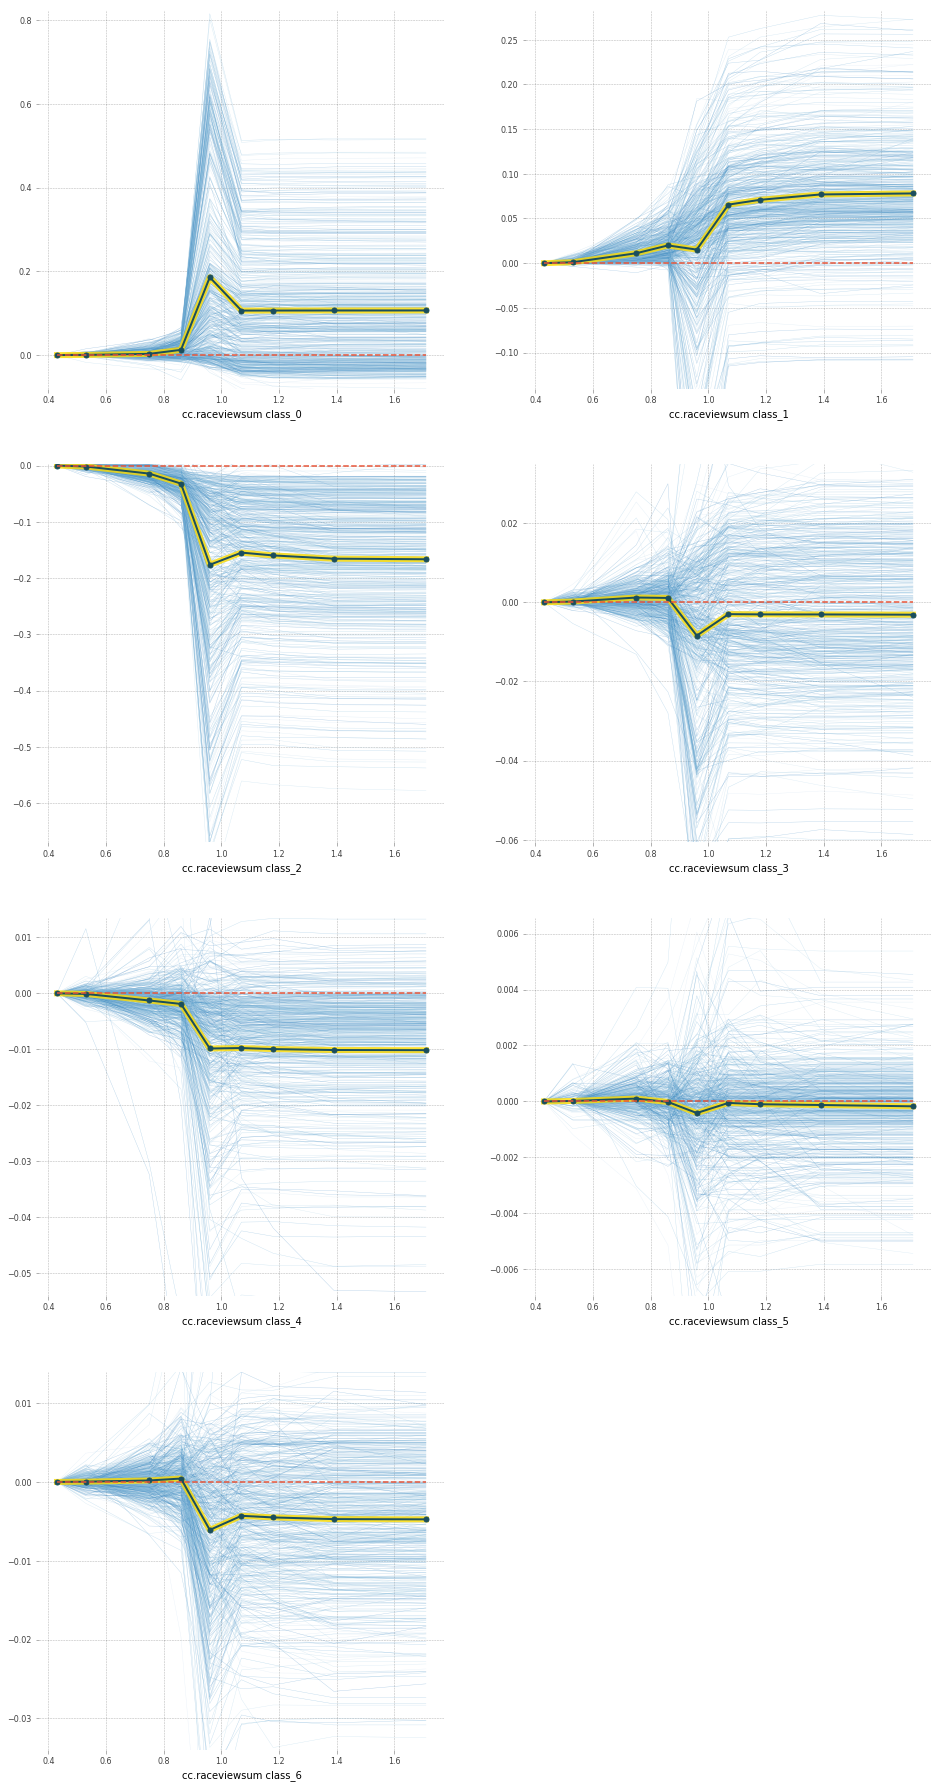

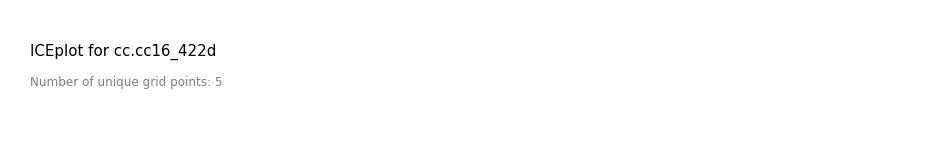

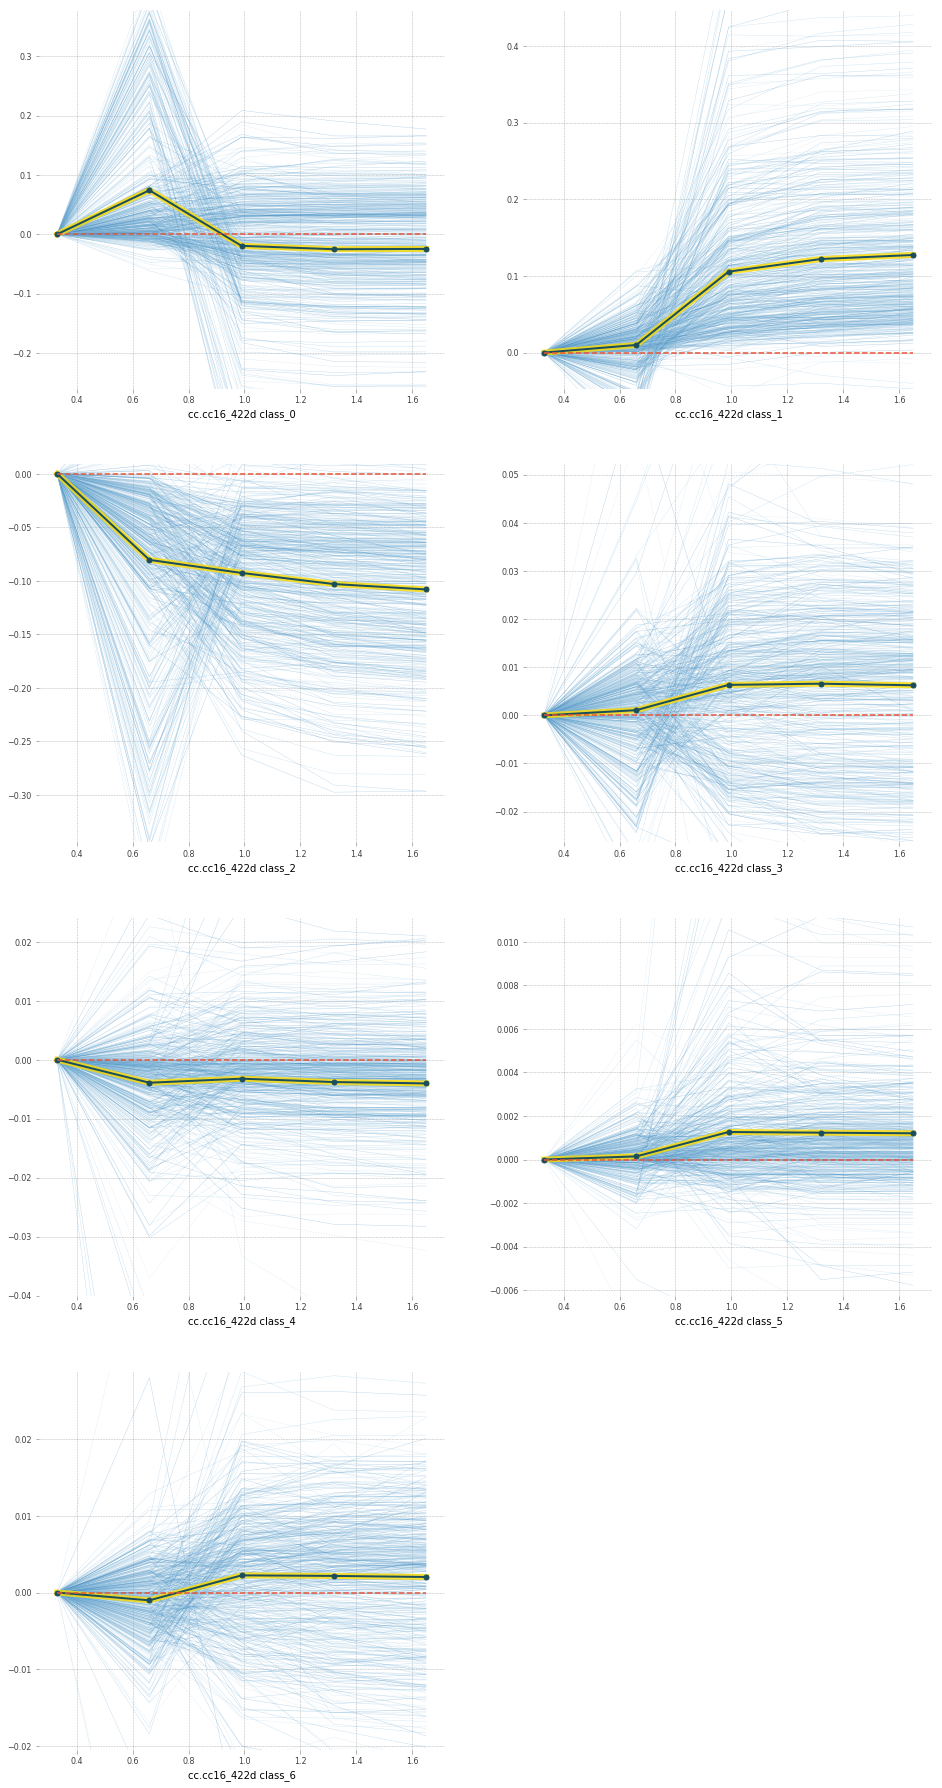

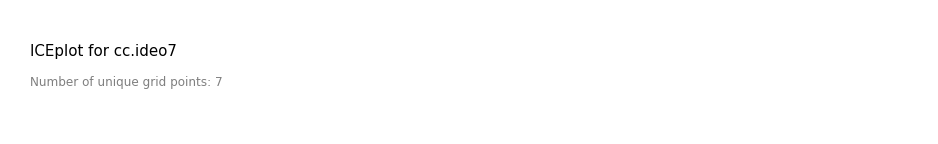

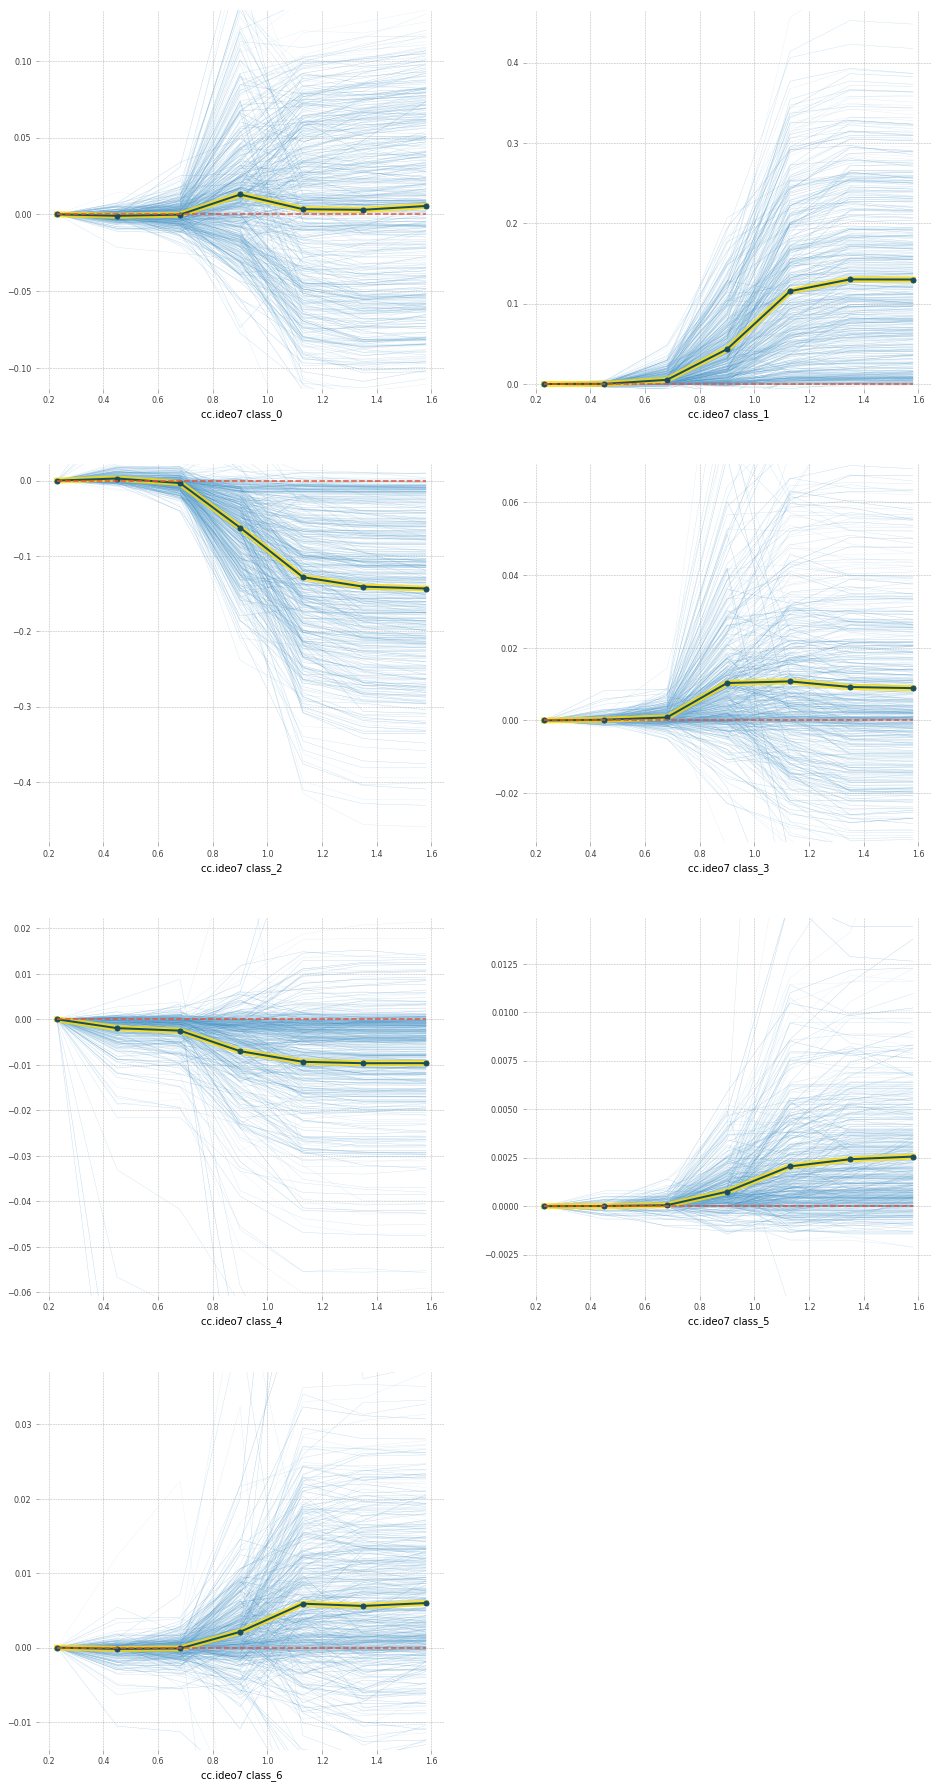

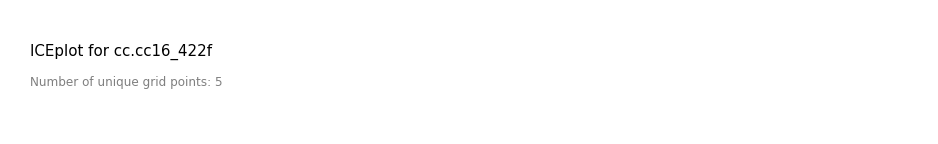

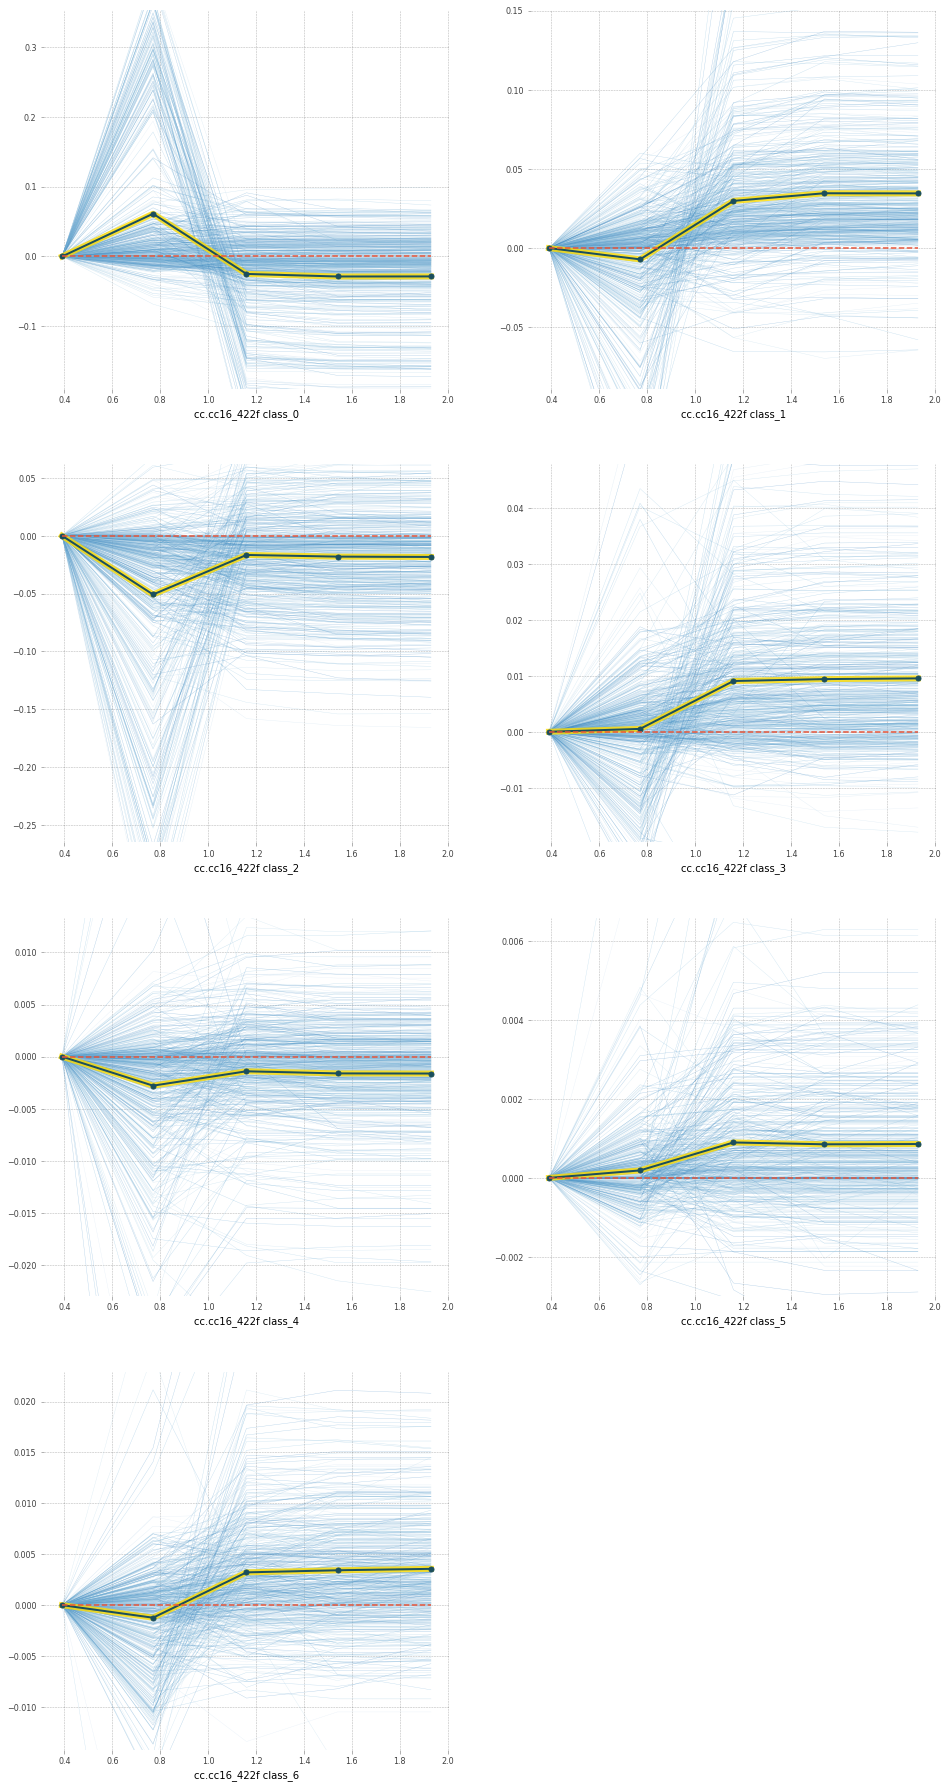

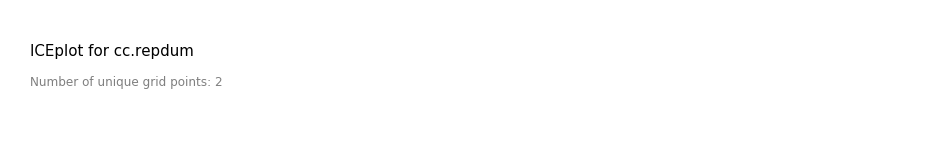

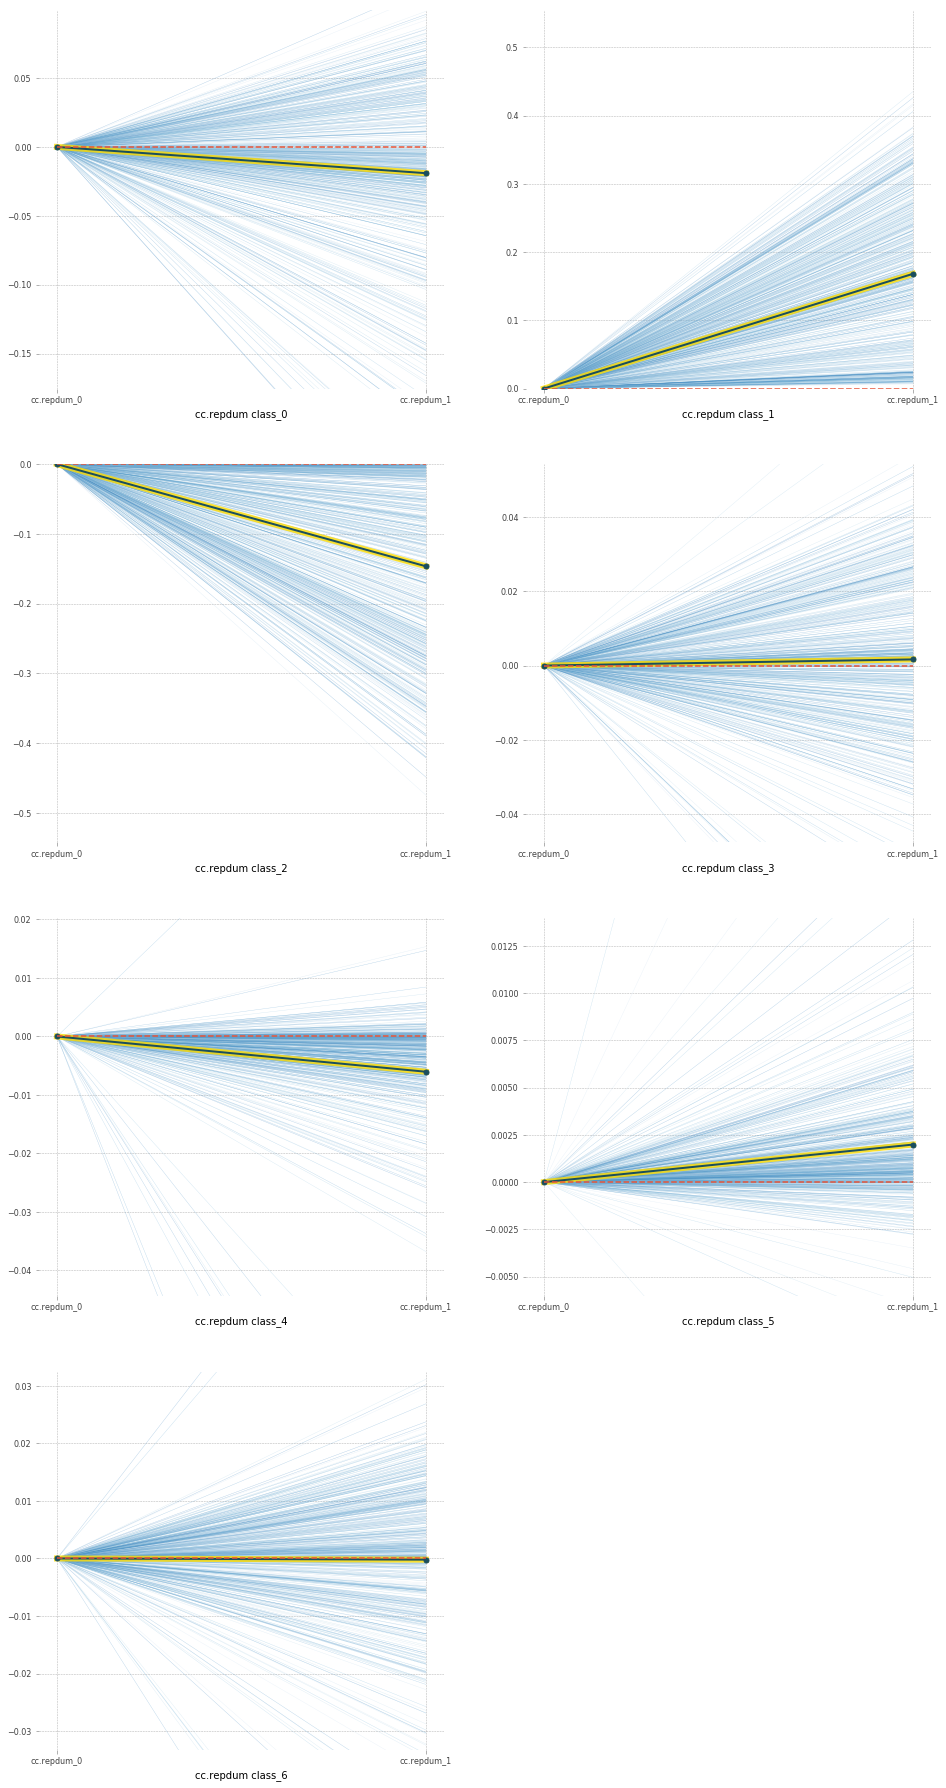

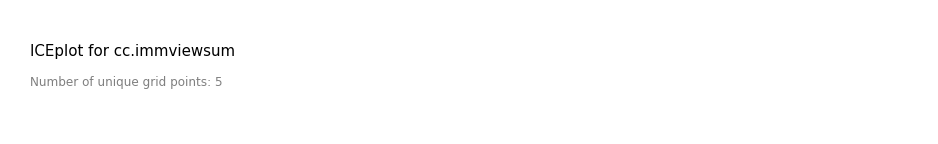

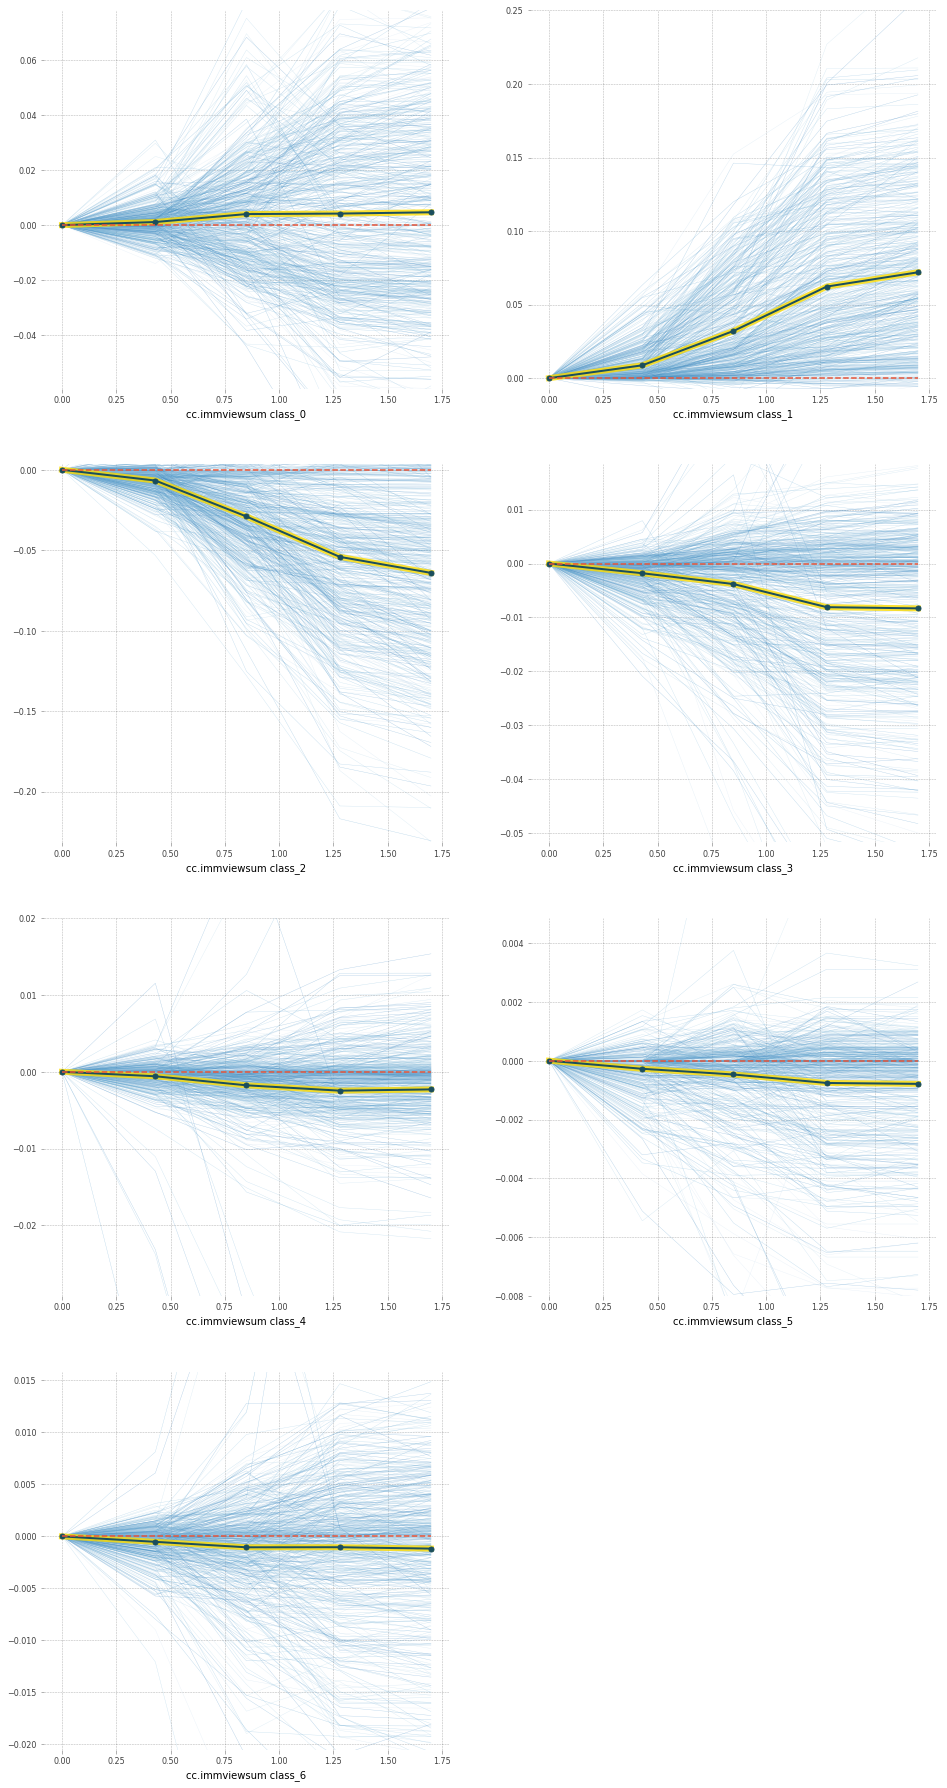

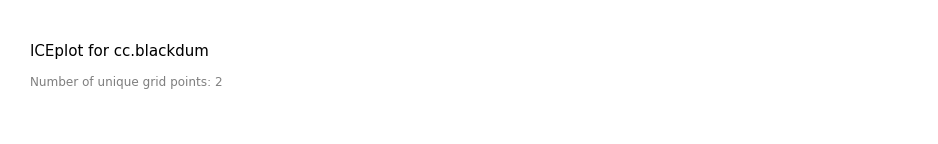

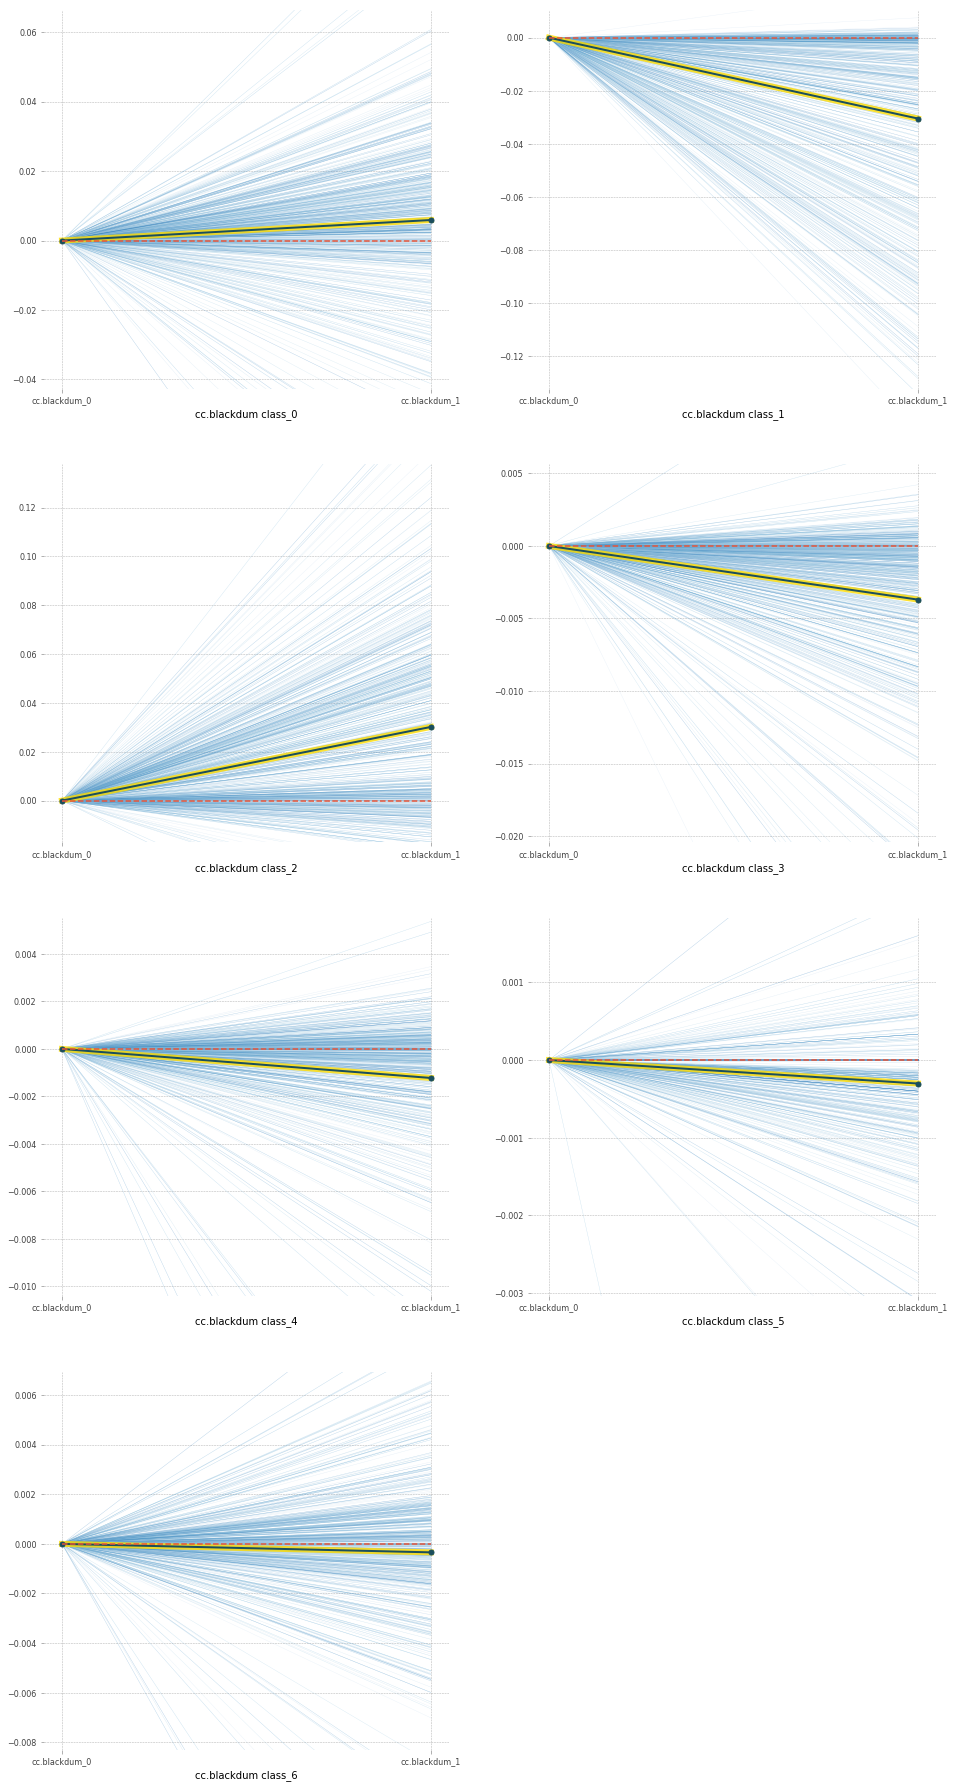

In [50]:
plot_pdp('cc.raceviewsum', m_rf, trn[:500])
plot_pdp('cc.cc16_422d', m_rf, trn[:500])
plot_pdp('cc.ideo7', m_rf, trn[:500])
plot_pdp('cc.cc16_422f', m_rf, trn[:500])
plot_pdp('cc.repdum', m_rf, trn[:500])
plot_pdp('cc.immviewsum', m_rf, trn[:500])
plot_pdp('cc.blackdum', m_rf, trn[:500])   #this is a bool, only 2 values so pdp should be linear

In [ ]:
feats=['cc.ideo7','cc.raceviewsum']
p=pdp.pdp_interact(m_rf, trn, feats)
pdp.pdp_interact_plot(p, feats)

# Conclusions and Next Steps
This model is 92.2% accurate with no data tweaks

# Scratch

In [ ]:
data = test[0]
data[31]
type(data)
data.shape
tmp=learn.predict(data)
len(tmp)
out,pred,res=tmp

out
pred
res

# len(out)
# len(pred)
len(res)